Automatically created module for IPython interactive environment


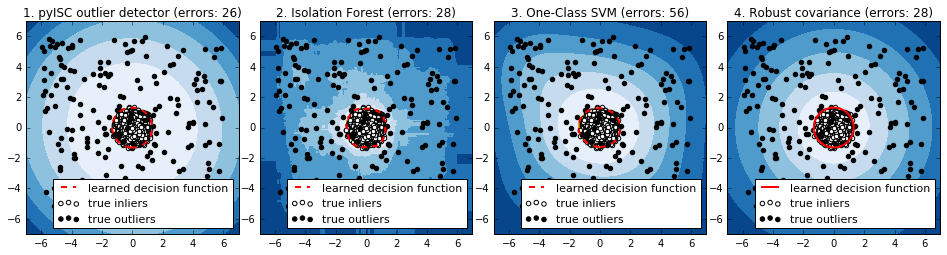

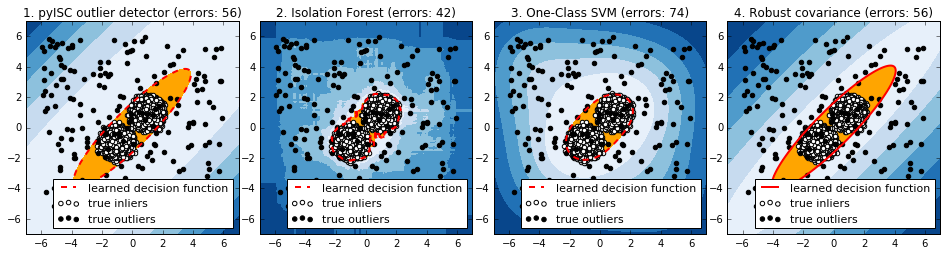

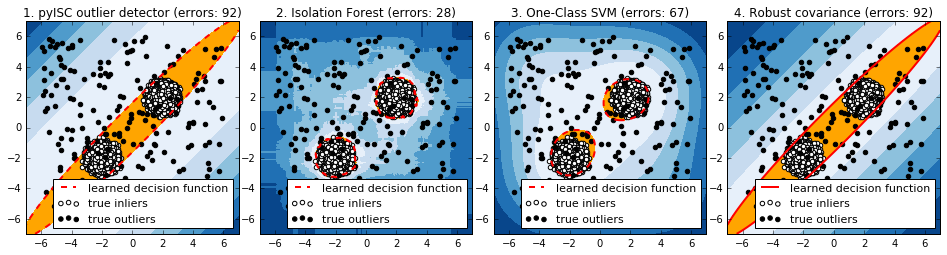

In [2]:
print(__doc__)
%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import pyisc

rng = np.random.RandomState(42)

# Example settings
n_samples = 200000
outliers_fraction = 0.001
clusters_separation = [0, 1, 2]

# define four outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + outliers_fraction/5.0,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "pyISC outlier detector": pyisc.SklearnOutlierDetector(outliers_fraction,pyisc.P_Gaussian([0,1]),
                                               pyisc.cr_plus)
}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(13.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, len(classifiers), i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11),
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
        #plt.figure();plt.hist(scores_pred,100);
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()

In [3]:
%timeit classifiers["pyISC outlier detector"].fit(X)

10 loops, best of 3: 178 ms per loop


In [4]:
%timeit classifiers["Isolation Forest"].fit(X)

1 loop, best of 3: 14 s per loop


In [5]:
%timeit classifiers["Robust covariance"].fit(X)

1 loop, best of 3: 33.5 s per loop


In [6]:
%timeit classifiers["One-Class SVM"].fit(X) 

1 loop, best of 3: 2.21 s per loop


In [7]:
%timeit classifiers["pyISC outlier detector"].predict(X)

10 loops, best of 3: 79.8 ms per loop


In [8]:
%timeit classifiers["Isolation Forest"].predict(X)

1 loop, best of 3: 8.99 s per loop


In [9]:
%timeit classifiers["Robust covariance"].predict(X)

100 loops, best of 3: 7.35 ms per loop


In [10]:
%timeit classifiers["One-Class SVM"].predict(X) 

1 loop, best of 3: 693 ms per loop


In [11]:
EllipticEnvelope.mahalanobis??